<a href="https://colab.research.google.com/github/patrick-seib/econ-416/blob/master/Relationship_Between_News_and_Asset_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **News and Asset Prices**
by Patrick Seib

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statistics

from google.colab import drive
drive.mount('/content/drive/')
xls = pd.ExcelFile('/content/drive/My Drive/dataEP2_2020.xlsx')
df_total = pd.read_excel(xls)
df_wsj = pd.read_excel(xls, 'WSJ Forecasting')
df_employment_changes = pd.read_excel(xls, 'Change in Non-Farm Employment')
df_sp = pd.read_excel(xls, 'S&P 500')
df_3m_bill = pd.read_excel(xls, '3m T-bill')
df_1yr_bill = pd.read_excel(xls, '1 year Bond')
df_10yr_bill = pd.read_excel(xls, '10 year Bond')

Mounted at /content/drive/


The first part of this analysis is to see how good the forecasters at the Wall Street Journal are at estimating the actual change in jobs effect.

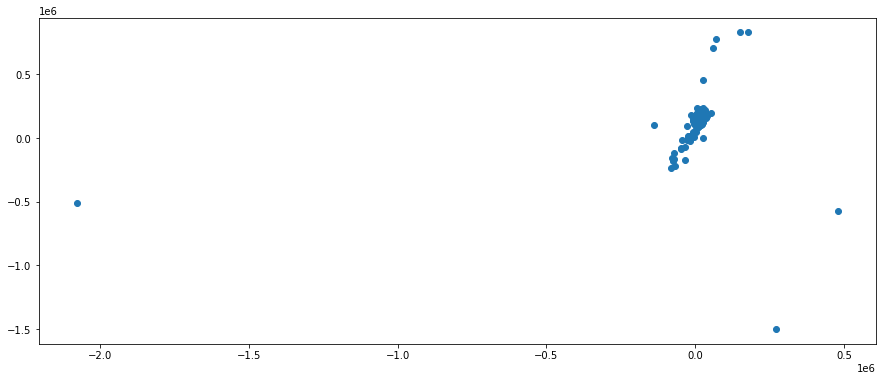

In [ ]:
fig = plt.figure(figsize=(15,6))
x_0 = df_wsj.Forecast[:168]
x_1 = df_employment_changes.Jobs[:168]

plt.scatter(x_1, x_0)

There are many ways to check the validity of the forecast, but I will use a t-test that compares the two means of the groups. Another useful tool will be simply looking at the plot of the two groups together.

In [ ]:
from scipy.stats import ttest_ind

# Running the Welch's t-test
ttest_ind(x_0, x_1, equal_var=False)

Ttest_indResult(statistic=6.364861678110199, pvalue=6.65262457850508e-10)

Given these results, we're able to reject the null hypothesis that the two means are equivalent. This is the first indicator that the WSJ forecasts may not be a good estimator for actual job movement.

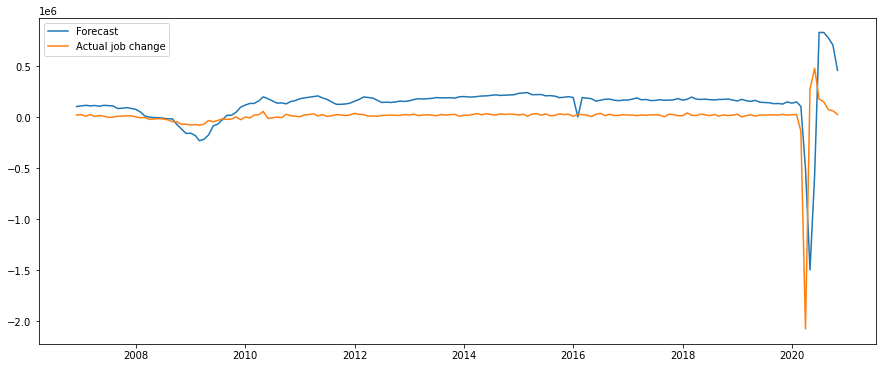

In [ ]:
fig = plt.figure(figsize=(15,6))
y = df_wsj.Date[:168]
plt.plot(y, x_0, label="Forecast")
plt.plot(y, x_1, label="Actual job change")

plt.legend()

Graphically analyzing this shows that when movement is small, the trends in the WSJ forecasts generally fall in line with the real data, even if it is consistently higher, but the outliers are far outside the grasp of the forecasts. 

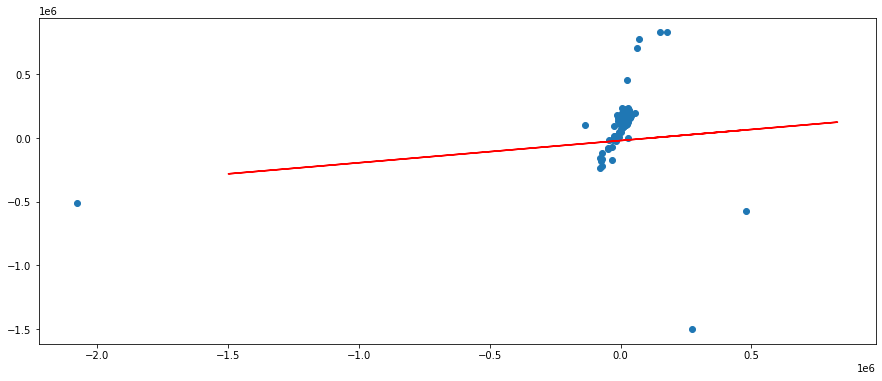

In [ ]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()

fig = plt.figure(figsize=(15,6))

#cleaning the data
df1 = df_employment_changes[df_employment_changes.Jobs.notnull()]
df2 = df_wsj.copy()
df2.drop(df2.tail(1).index, inplace=True)
X_0 = df2.iloc[:, 1].values.reshape(-1, 1)
X_1 = df1.iloc[:, 1].values.reshape(-1, 1)

#fitting regression
linear_regressor.fit(X_0, X_1)

plt.scatter(X_1,X_0)
Y_pred = linear_regressor.predict(X_0)
plt.plot(X_0, Y_pred, color='red')

This regression result shows the same result from the previous analysis, the variables plotted against each other show that outliers are very difficult to capture in the model, and there is a lot of concentration around 0. The forecasted values account for the majority of the upper bound.

The next part of this analysis is measuring the volatility of asset returns. To measure volatility, I'll compare the variance between each series of the s&p 500 data, and also all of the T-Bill returns.

In [ ]:
df_sp.var(numeric_only=True)

-2.0    0.000125
-1.0    0.000118
0.0     0.000156
1.0     0.000132
2.0     0.000140
dtype: float64

The highest variance for s&p500 returns happens on the day of the data release, and it's lowest the day before. However, it "explains" very little of the data at all.

In [ ]:
df_3m_bill.var(numeric_only=True)

-2.0    0.062532
-1.0    0.056721
0.0     0.025476
1.0     0.223396
2.0     0.019768
dtype: float64

The day after the release of the data release has by far the highest variance for 3m t-bills, which speaks to the volatility of the asset generally.

In [ ]:
df_1yr_bill.var(numeric_only=True)

-2.0    0.002511
-1.0    0.003173
0.0     0.005369
1.0     0.003685
2.0     0.004743
dtype: float64

As expected, 1 year t-bills have a lower variance than 3 month bills. The variance is highest on the day of the release of the data.

In [ ]:
df_10yr_bill.var(numeric_only=True)

-2.0    0.000825
-1.0    0.000801
0.0     0.001225
1.0     0.001137
2.0     0.001598
dtype: float64

The variance of 10 year bills is extremely small, but is highest at 2 days out after the release of the data.

The next part of this analysis is to estimate the relationship between effect of employment numbers on each asset.

In [ ]:
#reshaping employment change data
df1 = df_employment_changes[df_employment_changes.Jobs.notnull()]
Y = df1.iloc[:, 1].values.reshape(-1,1)

#reshaping sp, 3m, 1yr, and 10yr data to match employement changes data
df_sp_reshaped = df_sp.copy()
df_sp_reshaped.drop(df_sp_reshaped.tail(4).index, inplace=True)

df_3m_reshaped = df_3m_bill.copy()
df_3m_reshaped.drop(df_3m_reshaped.tail(4).index, inplace=True)

df_1yr_reshaped = df_1yr_bill.copy()
df_1yr_reshaped.drop(df_1yr_reshaped.tail(4).index, inplace=True)

df_10yr_reshaped = df_10yr_bill.copy()
df_10yr_reshaped.drop(df_10yr_reshaped.tail(4).index, inplace=True)


def get_r_squared(dataframe, y_value):
  #### Function that calculates the r-squared values of the fitted regression
  #### given a two series objects. This function returns all 5 R^2 from the
  #### -2 to +2 days after a data release in order

  X_1 = dataframe.iloc[:, 1].values.reshape(-1, 1)
  X_2 = dataframe.iloc[:, 2].values.reshape(-1, 1)
  X_3 = dataframe.iloc[:, 3].values.reshape(-1, 1)
  X_4 = dataframe.iloc[:, 4].values.reshape(-1, 1)
  X_5 = dataframe.iloc[:, 5].values.reshape(-1, 1)

  #initialize regressor object
  linear_regressor = LinearRegression()

  #fits the regressions and then calculates and prints the R^2 value
  linear_regressor.fit(y_value, X_1)
  print(linear_regressor.score(y_value, X_1))
  linear_regressor.fit(y_value, X_2)
  print(linear_regressor.score(y_value, X_2))
  linear_regressor.fit(y_value, X_3)
  print(linear_regressor.score(y_value, X_3))
  linear_regressor.fit(y_value, X_4)
  print(linear_regressor.score(y_value, X_4))
  linear_regressor.fit(y_value, X_5)
  print(linear_regressor.score(y_value, X_5))

get_r_squared(df_sp_reshaped, Y)

0.032856968139300835
0.0016646469489673965
0.0032710534002389213
0.0025105220941968875
1.9174834670399044e-05


The R^2 values for the s&p 500 data show that a linear regression is a poor estimator for capturing the trends of the data, meaning that the linear relationship between s&p 500 data and employment numbers is weak.

In [ ]:
get_r_squared(df_3m_reshaped, Y)

0.00019700028346736342
2.8464244382631065e-05
4.413427955485272e-05
0.0008891391964598316
0.0007250756296905969


The greatest influence the actual data has on the price of a 3m bond return is even smaller than the s&p500 asset influence, but is largest the day after the release.

In [ ]:
get_r_squared(df_1yr_reshaped, Y)

0.006314290373170883
0.007315389826179963
0.00019637883979084503
0.012240738562334319
0.0019916861294579924


One year t-bills seem to have the largest reaction to employment numbers, but it's still relatively small.

In [ ]:
get_r_squared(df_10yr_reshaped, Y)

0.01970728569508773
1.8660779084966883e-05
0.002419468806119207
0.00012777230933169736
0.010325151345771277


The employment values are still a very small proportion of the explained data.

The next part of this analysis will measure the effect of the "surprise" on asset prices. Starting with s&p500 data..

In [ ]:
forecast = df_wsj.Forecast[:168]
release = df_employment_changes.Jobs[:168]

news = forecast - release

news = news.reset_index().to_numpy()
print("S&P 500 Data")
get_r_squared(df_sp_reshaped, news)
print("3m T-Bills")
get_r_squared(df_3m_reshaped, news)
print("1yr T-Bills")
get_r_squared(df_1yr_reshaped, news)
print("10yr T-Bills")
get_r_squared(df_10yr_reshaped, news)

S&P 500 Data
0.061732742888676806
0.005633591259457504
0.04906734436452542
0.00810747206330309
0.009120266275717936
3m T-Bills
0.010942671890887379
0.0036471016094234976
0.002753516161374092
0.0007312137036959987
0.010898864646249229
1yr T-Bills
0.0537404277801119
0.07043891394309598
0.00944240833961163
0.003066647886878271
0.08396981758456223
10yr T-Bills
0.06914989601248478
0.042002118648391096
0.12263258546331357
0.11513951079002838
0.43137148974306727


The explained portion of the asset price change by the "surprise" is larger than any of the actual effects of employment change. It seems that the surprise has the largest effect on the returns of 10yr bonds.

Then, we check the effect of the forecast on asset prices

In [ ]:
forecast = forecast.reset_index().to_numpy()

print("S&P 500 Data")
get_r_squared(df_sp_reshaped, forecast)
print("3m T-Bills")
get_r_squared(df_3m_reshaped, forecast)
print("1yr T-Bills")
get_r_squared(df_1yr_reshaped, forecast)
print("10yr T-Bills")
get_r_squared(df_10yr_reshaped, forecast)

S&P 500 Data
0.022042874050590133
0.00316657007059018
0.0839103357198987
0.014005695198304746
0.0102482991861792
3m T-Bills
0.011574495996686252
0.0054680679075326255
0.004556424840863937
0.0031609613048898533
0.009899808887413486
1yr T-Bills
0.0416584859517074
0.05680943208423217
0.015360996861662368
0.009185329491789074
0.08868594455932488
10yr T-Bills
0.03534350299081701
0.05992503936874394
0.206781316276356
0.16746533187280155
0.467441047572009


It seems that there is a larger proportion of the data explained by forecasts than either the real employment numbers or the "surprise". This also might be an indirect effect, because the forecast was usually quite a bit higher than the actual return numbers. If there were other factors causing the high average asset returns, such as low interest rates causing asset price inflation outside productivity increases, that could make the on average high forecast look like a better estimator than it actually is.